<font size="+2"><strong>AirQuality in Dar_es_Salaam</strong></font>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [3]:
# Function to read and clean data
def wrangle_data(csv):
    # Read data for data frame
    df = pd.read_csv(csv)

    df[['sensor_id','sensor_type', 'location', 'lat', 'lon', 'timestamp', 'value_type', 'value']] = (
        df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"]
        .str
        .split(";", expand = True)
    )
    df.drop(columns = "sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value", inplace = True)

    # Set timestamp as index
    df = df.set_index("timestamp")

    # Change to Datetime
    df.index = pd.to_datetime(df.index)

    #Localize Timezone
    city = csv.split(".")[0]
    df.index.tz_convert(f"Africa/{city}")

    # Drop Nan values


    # Since we are only focused on air quality, get only P2 readings

    df['value_type'] = df['value_type'].astype(str)
    df['value'] = df['value'].astype(float)
    return df

In [5]:
df_dar = wrangle_data('Dar_es_Salaam.csv')
print(df_dar.info())
df_dar.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190028 entries, 2019-04-01 00:02:19.304629+00:00 to 2019-06-28 16:35:06.947380+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    190028 non-null  object 
 1   sensor_type  190028 non-null  object 
 2   location     190028 non-null  object 
 3   lat          190028 non-null  object 
 4   lon          190028 non-null  object 
 5   value_type   190028 non-null  object 
 6   value        190028 non-null  float64
dtypes: float64(1), object(6)
memory usage: 11.6+ MB
None


,sensor_id,sensor_type,location,lat,lon,value_type,value
timestamp,,,,,,,
2019-04-01 00:02:19.304629+00:00,67,SDS011,42,-6.772,39.269,P2,10.50
2019-04-01 00:02:19.304629+00:00,67,SDS011,42,-6.772,39.269,P1,21.33
2019-04-01 00:02:20.770728+00:00,68,DHT22,42,-6.772,39.269,humidity,99.90
2019-04-01 00:02:20.770728+00:00,68,DHT22,42,-6.772,39.269,temperature,30.30
2019-04-01 00:04:50.640412+00:00,67,SDS011,42,-6.772,39.269,P2,10.50


In [6]:
# Since we are only focused on air quality, get only P2 readings
mask = df_dar['value_type'] == 'P2'
filtered_data = df_dar[mask]['value']

# Create a new DataFrame from the filtered data
df = pd.DataFrame({'P2': filtered_data})
df.head()

,P2
timestamp,
2019-04-01 00:02:19.304629+00:00,10.50
2019-04-01 00:04:50.640412+00:00,10.50
2019-04-01 00:07:20.824552+00:00,10.33
2019-04-01 00:09:51.193712+00:00,11.50
2019-04-01 00:12:23.280002+00:00,20.87


In [7]:
df.shape

(49990, 1)

<Axes: title={'center': 'Distrubition of PM2.5 Readings'}>

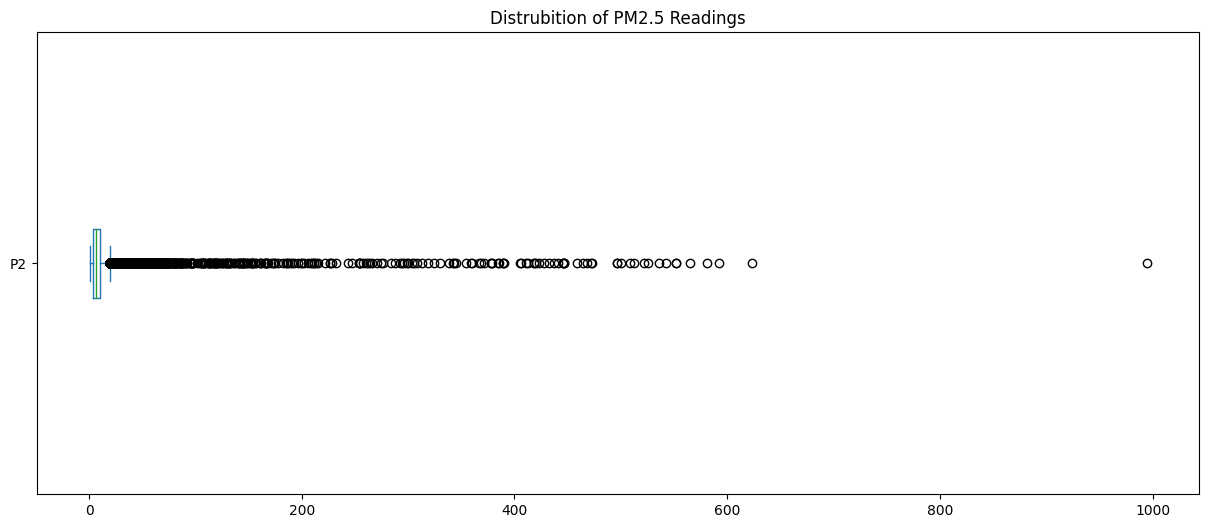

In [8]:
# Boxplot of the "P2" readings in df
fig, ax = plt.subplots(figsize=(15, 6))
df['P2'].plot(kind = "box", vert = False, title = "Distrubition of PM2.5 Readings", ax = ax)

In [9]:
# Check further details of the DataFrame
print(df.describe())
df.quantile([0.1, 0.999])

                 P2
count  49990.000000
mean       9.084313
std       19.248441
min        0.600000
25%        3.770000
50%        6.100000
75%       10.030000
max      994.270000


,P2
0.100,2.53000
0.999,354.16017


##### There are a couple of outliers, and the maximum, when compared to the 99.9th percentile, is too large. Therefore, we will remove some values from the dataset.

In [10]:
mask_outliers = df["P2"] <= 400
df = df[mask_outliers]

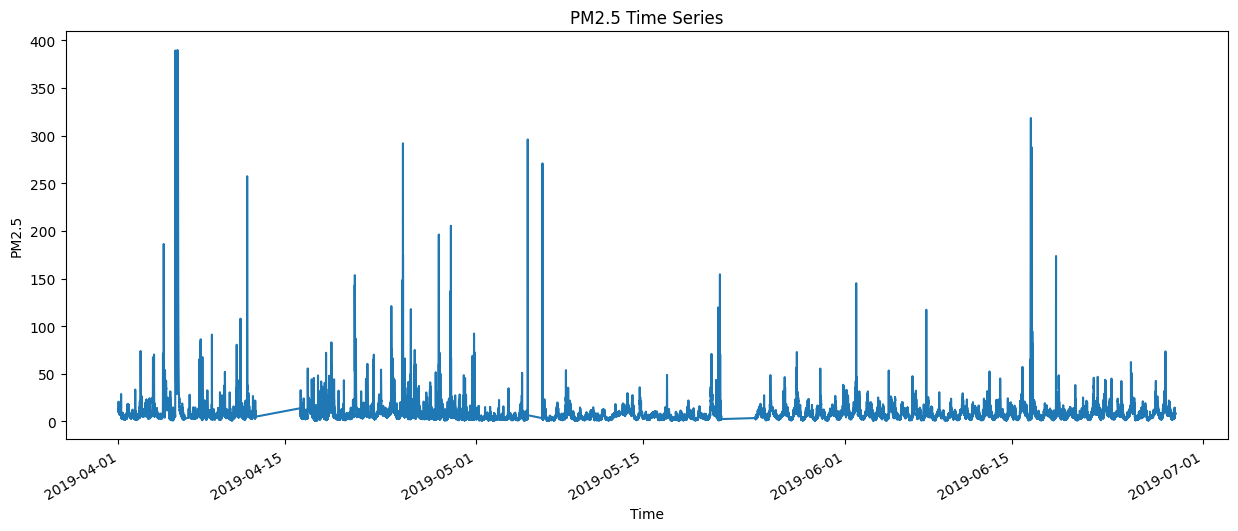

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))

df['P2'].plot(xlabel = "Time", ylabel = "PM2.5", title = "PM2.5 Time Series",ax = ax);

In [12]:
df.shape

(49953, 1)

### **Resampling Data**

The "timestamp" data tells us when each reading was taken, but in order to create a good predictive model, we need the readings to happen at regular intervals. The data doesn't do that, so it needs to be changed. The resample method does that for us.

In [13]:
# Resample data to create 1-hour reading intervals by aggregating using the mean (i.e average -M2.5 reading in a given hour)
df = df["P2"].resample("1H").mean().fillna(method = "ffill").to_frame()
df.head()

,P2
timestamp,
2019-04-01 00:00:00+00:00,11.613500
2019-04-01 01:00:00+00:00,9.219167
2019-04-01 02:00:00+00:00,9.232083
2019-04-01 03:00:00+00:00,9.374583
2019-04-01 04:00:00+00:00,13.673750


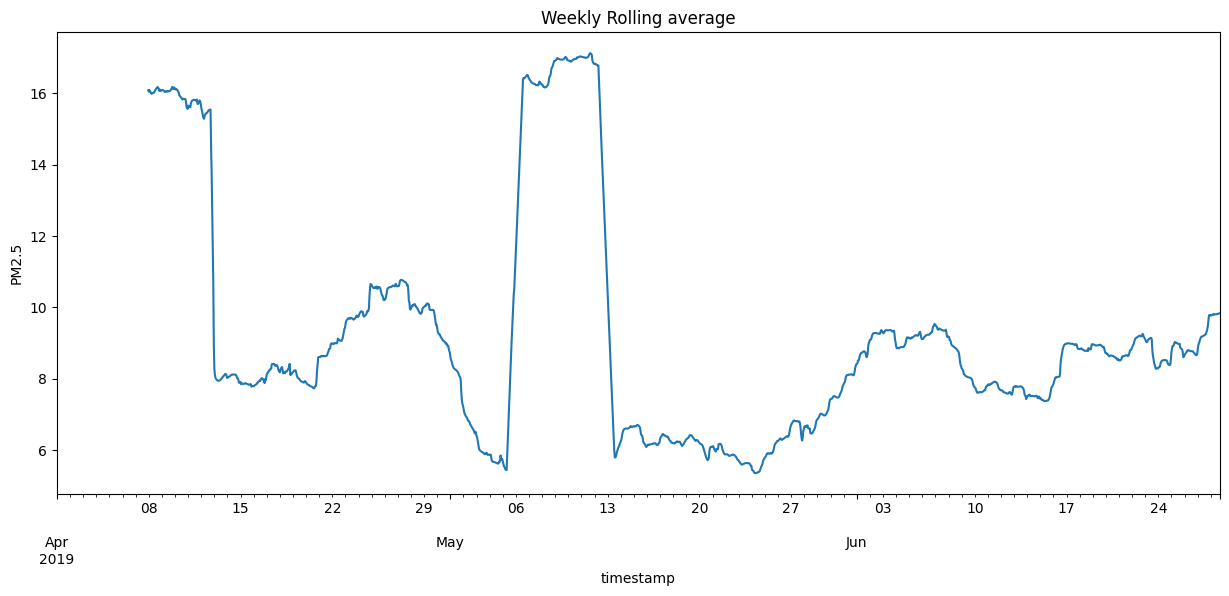

In [14]:
# Plot of the rolling average of the "P2" readings using a window size of 168 (the number of hours in a week).
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].rolling(168).mean().plot(ax = ax, ylabel = "PM2.5", title = "Weekly Rolling average" );

In [15]:
#Add lag feature to make data suitable for modelling
df["P2.L1"] = df["P2"].shift(1)
#Drop Nan values
df.dropna(inplace = True)

df.head()

,P2,P2.L1
timestamp,,
2019-04-01 01:00:00+00:00,9.219167,11.613500
2019-04-01 02:00:00+00:00,9.232083,9.219167
2019-04-01 03:00:00+00:00,9.374583,9.232083
2019-04-01 04:00:00+00:00,13.673750,9.374583
2019-04-01 05:00:00+00:00,11.700417,13.673750


Checking the correlation between what happened in the previous hour and what is happening now.

In [16]:
df.corr()

,P2,P2.L1
P2,1.000000,0.818631
P2.L1,0.818631,1.000000


There is a pretty strong correlation between the 2 readings. Further details can be seen using the scatter plot below:


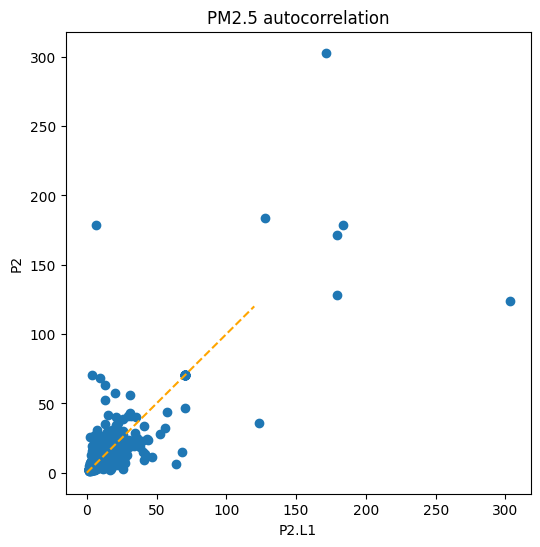

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x = df["P2.L1"], y = df["P2"])
ax.plot([0, 120], [0,120], linestyle = "--", color = "orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 autocorrelation");

The line is symmetrical which further reinstates the above inference on the Correlation Co-efficient.

### **Linear Regression Model for Predicting Air Quality**

DataFrame is split into into the feature matrix X and the target vector y

In [18]:
y = df['P2']
X = df.drop(columns = 'P2')
X

,P2.L1
timestamp,
2019-04-01 01:00:00+00:00,11.613500
2019-04-01 02:00:00+00:00,9.219167
2019-04-01 03:00:00+00:00,9.232083
2019-04-01 04:00:00+00:00,9.374583
2019-04-01 05:00:00+00:00,13.673750
...,...
2019-06-28 12:00:00+00:00,3.947000
2019-06-28 13:00:00+00:00,4.399545
2019-06-28 14:00:00+00:00,4.409130


In [19]:
# Split into training and test sets
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [20]:
# Calculating the baseline mean absolute error
y_pred_baseline = len(y_train) * [y_train.mean()]
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.46
Baseline MAE: 6.43


In [21]:
# Instantiating the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
#  Calculating the training and test mean absolute error of the model
y_pred_training = model.predict(X_train)
y_pred_test = model.predict(X_test)

training_mae = mean_absolute_error(y_train, y_pred_training)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 3.14
Test MAE: 2.56


The test MAE looks good but can be improved.

### **Model's results**

In [24]:
# Extracting the intercept and coefficient from the model
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 1.69 + ([0.82] * P2.L1)


In [25]:
# Visualizing model's result
df_pred_test = pd.DataFrame(
    {
        "y_test" : y_test,
        "y_pred" : y_pred_test
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2019-06-10 23:00:00+00:00,8.931667,10.642875
2019-06-11 00:00:00+00:00,8.554167,9.025939
2019-06-11 01:00:00+00:00,5.783750,8.715833
2019-06-11 02:00:00+00:00,5.184583,6.440006
2019-06-11 03:00:00+00:00,8.248333,5.947806


In [26]:
#  Time series line plot showing the result of the model.
fig = px.line(df_pred_test, labels = {"value" : "P2"})
fig.show();

### **AutoRegressive Model for Predicting Air Quality**

In the previous section, autocorrelations were treated as static relationships, but that's not always how they work. Sometimes, it is necessary to observe how these autocorrelations change over time. This can be accomplished by using an ACF plot.

In [27]:
y = df['P2']
y

timestamp
2019-04-01 01:00:00+00:00     9.219167
2019-04-01 02:00:00+00:00     9.232083
2019-04-01 03:00:00+00:00     9.374583
2019-04-01 04:00:00+00:00    13.673750
2019-04-01 05:00:00+00:00    11.700417
                               ...    
2019-06-28 12:00:00+00:00     4.399545
2019-06-28 13:00:00+00:00     4.409130
2019-06-28 14:00:00+00:00     4.434348
2019-06-28 15:00:00+00:00     7.987083
2019-06-28 16:00:00+00:00     8.481429
Freq: H, Name: P2, Length: 2128, dtype: float64

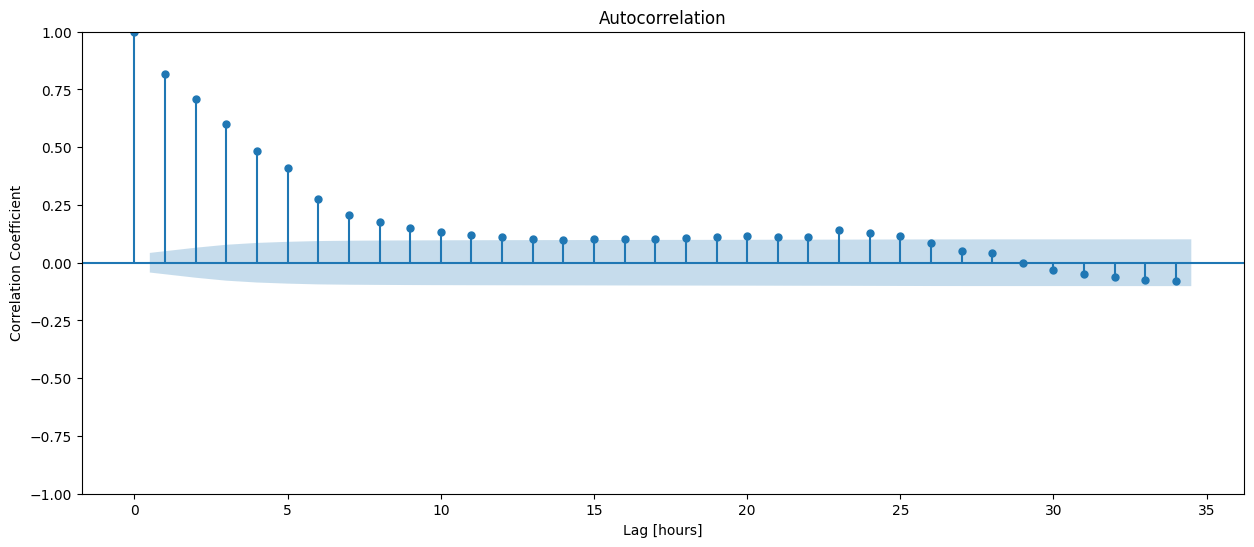

In [28]:
# Plotting an ACF plot
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(y, ax = ax)

plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

Comparing the ACF and PACF plots to determine which model best describes the time series. If the ACF data decreases slowly, then that's likely to be a better description; if the PACF decreases slowly, then that's also likely to be a better description.

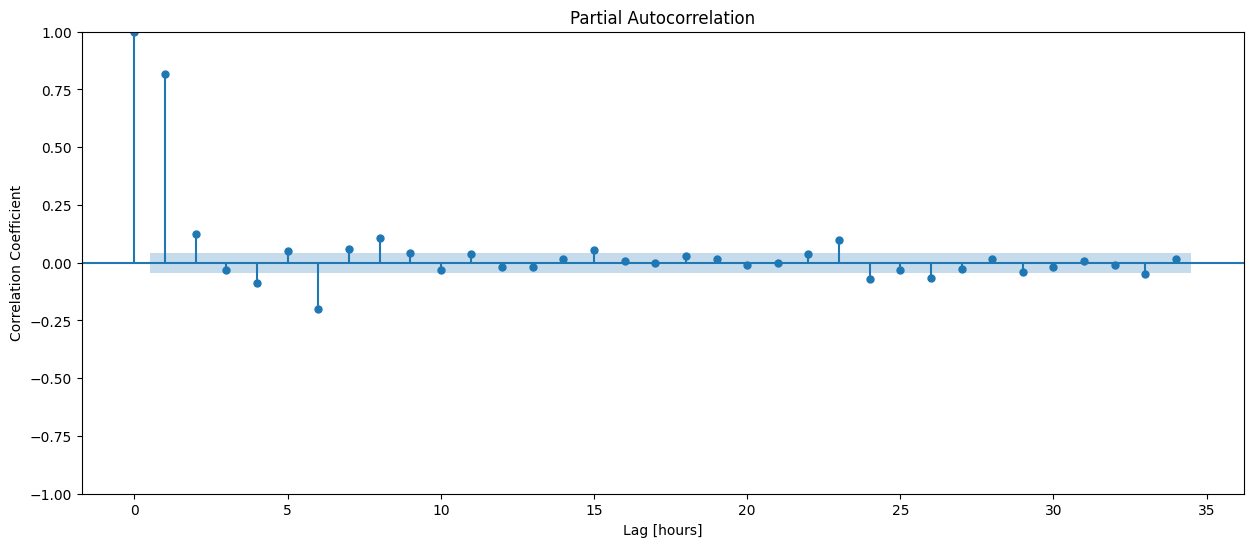

In [29]:
# Plotting a PACF plot
fig, ax = plt.subplots(figsize=(15, 6))

plot_pacf(y, ax=ax)

plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [39]:
# Split into training and test sets
cutoff_test = int(len(y) * 0.95)

y_train_auto = y.iloc[:cutoff_test] #everything upwards from 2781
y_test_auto = y.iloc[cutoff_test:]  #everything downwards from 2781

In [31]:
# Calculating the baseline mean absolute error for the model
y_train_mean = y_train_auto.mean()
y_pred_baseline = [y_train_mean] * len(y_train_auto)
mae_baseline = mean_absolute_error(y_train_auto, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.35
Baseline MAE: 6.07


In [32]:
# Instantiating an AutoReg model to fit it to the training data y_train.
model_auto = AutoReg(y_train_auto, lags = 26).fit()

In [33]:
y_pred_auto = model_auto.predict().dropna()
training_mae_auto = mean_absolute_error(y_train_auto[26:], y_pred_auto)
print("Training MAE:", training_mae_auto)

Training MAE: 3.319298237674964


#### **Model residuals**

In [34]:
# Calculating the residuals for the model to assess how well the model fits the observed data.
y_train_resid = model_auto.resid
y_train_resid.tail()

timestamp
2019-06-24 01:00:00+00:00   -1.554181
2019-06-24 02:00:00+00:00   -0.443832
2019-06-24 03:00:00+00:00    6.465814
2019-06-24 04:00:00+00:00    6.385403
2019-06-24 05:00:00+00:00   -3.476345
Freq: H, dtype: float64

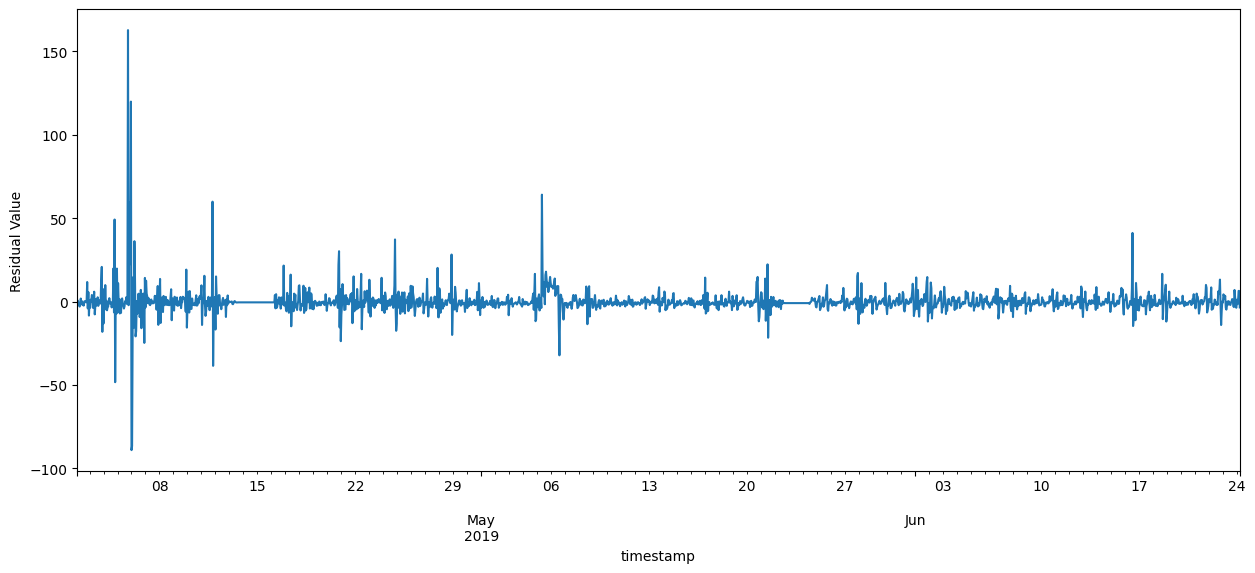

In [35]:
# Visualizing to show more information
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax=ax);

The values that are above 0 are the ones where the true value was vastly underestimated and below 0 are the overestimated values. Generally, for a good model, the residual should be distributed around 0.

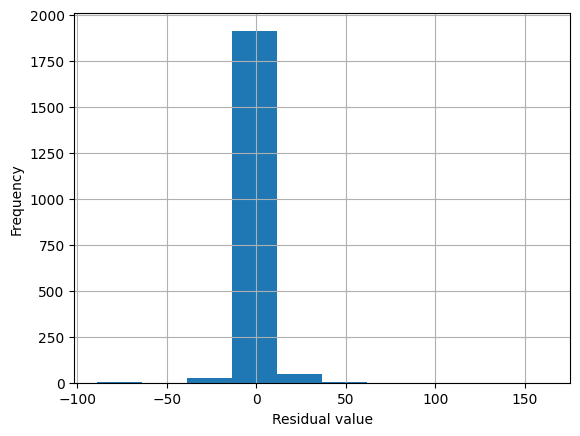

In [36]:
y_train_resid.hist()
plt.xlabel("Residual value")
plt.ylabel("Frequency");

The above diagram reinforces the previous statement showing the residual values distributed around 0

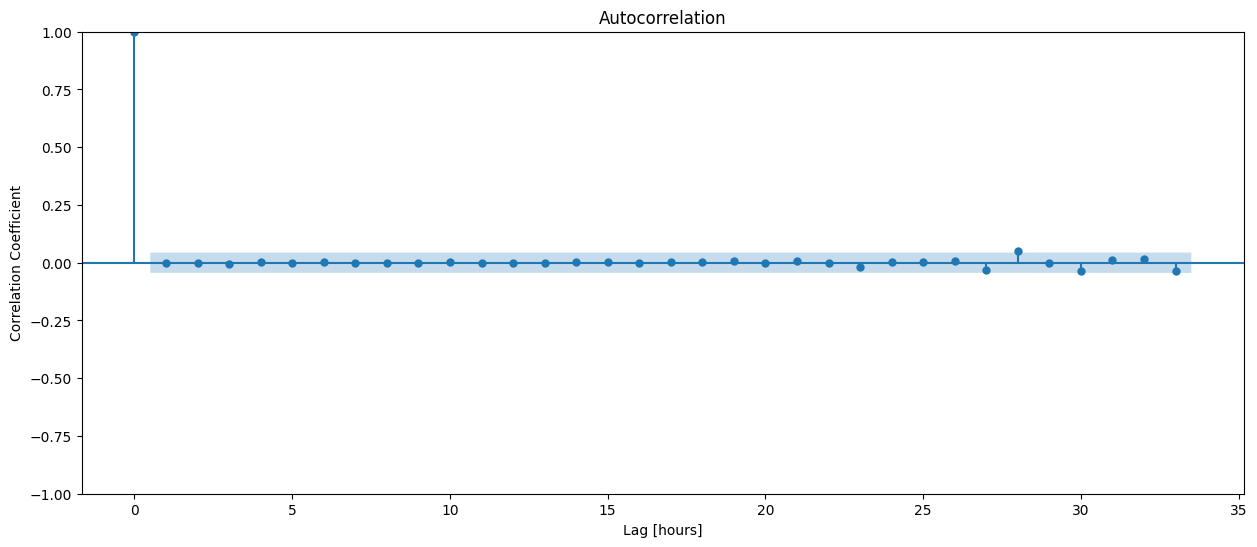

In [37]:
# Creating an ACF plot of y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)

plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

The above diagram shows that there is no way to predict a residual with past residuals, i.e there is no more signal left in our signal/data and the model already removed or pulled all that signal / predicted power during training.

### **Model's results**

In [40]:
# Calculating the mean test absolute error
y_pred_test = model_auto.predict(y_test_auto.index.min(), y_test_auto.index.max())
test_mae = mean_absolute_error(y_test_auto, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 5.327764758791985


In [41]:
# Visualizing model's result
df_pred_test_auto = pd.DataFrame(
    {
        "y_test" : y_test_auto,
        "y_pred" : y_pred_test
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2019-06-10 23:00:00+00:00,8.931667,10.642875
2019-06-11 00:00:00+00:00,8.554167,9.025939
2019-06-11 01:00:00+00:00,5.783750,8.715833
2019-06-11 02:00:00+00:00,5.184583,6.440006
2019-06-11 03:00:00+00:00,8.248333,5.947806


In [42]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

From the above, it can be seen that this isn't a very good model. The red line should follow the test data, not a straight line. This shows that Autoregression models can't be tested in the same way as linear regression models. To test this, walk-forward validation is performed on the entire test set.

#### **Walk-Forward Validation**

In [43]:
%%capture
# Performing walk-forward validation for the model
y_pred_wfv = pd.Series()
history = y_train_auto.copy()
for i in range(len(y_test_auto)):
    model = AutoReg(history, lags = 26).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

In [44]:
# Calculating the test mean absolute error for the model.
test_mae = mean_absolute_error(y_test_auto, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 2.96


This demonstrates an higher Mean Absolute Error (MAE) compared to when the modeling was conducted without walk-forward validation

#### **Model's New Result**

In [45]:
df_pred_test = pd.DataFrame(
    {"y_test" : y_test_auto, "y_pred_wfv" : y_pred_wfv}
)
fig = px.line(df_pred_test, labels = {"value" : "PM2.5"})
fig.show()

Now we can see the model is doing a much better job at predicting